<a href="https://colab.research.google.com/github/gourav10/autoencoder_embedding/blob/main/autoencoder_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Gopal Krishna, Goura Beura, Heet Sakaria
Date: 12/15/22
CS 7180

In [1]:
from google.colab import drive
import os

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
!export PYTHONPATH=$PYTHONPATH:"/content/gdrive/MyDrive/CS7180"

In [5]:
%cd /content/gdrive/MyDrive/CS7180

/content/gdrive/MyDrive/CS7180


In [6]:
!pwd

/content/gdrive/MyDrive/CS7180


In [7]:
!git clone https://github.com/gourav10/autoencoder_embedding.git

fatal: destination path 'autoencoder_embedding' already exists and is not an empty directory.


In [8]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [9]:
%cd /content/gdrive/MyDrive/CS7180/autoencoder_embedding

/content/gdrive/MyDrive/CS7180/autoencoder_embedding


In [10]:
DATA_DIR = '/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/'

In [11]:
import os
os.makedirs(DATA_DIR,exist_ok=True)

In [12]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio
pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

In [13]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root=DATA_DIR, train=True,
                                   download=True)#, transform=transform)
test_data = datasets.MNIST(root=DATA_DIR, train=False,
                                  download=True)#, transform=transform)

In [14]:
# Create training and test dataloaders
num_workers = 0

# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

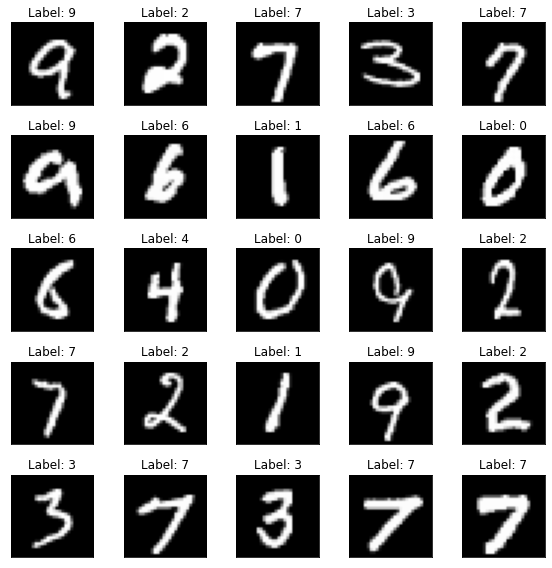

In [15]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_data)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [16]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [17]:
m=len(train_data)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_data, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

# 2. Define Autoencoders

In [18]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [19]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [20]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

In [21]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_data[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [22]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
#optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=6e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [23]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [24]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [25]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_data[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

	 partial train loss (single batch): 0.253518
	 partial train loss (single batch): 0.246519
	 partial train loss (single batch): 0.240348
	 partial train loss (single batch): 0.236322
	 partial train loss (single batch): 0.232132
	 partial train loss (single batch): 0.228801
	 partial train loss (single batch): 0.225099
	 partial train loss (single batch): 0.222226
	 partial train loss (single batch): 0.219920
	 partial train loss (single batch): 0.218012
	 partial train loss (single batch): 0.215520
	 partial train loss (single batch): 0.213688
	 partial train loss (single batch): 0.211404
	 partial train loss (single batch): 0.209156
	 partial train loss (single batch): 0.206987
	 partial train loss (single batch): 0.205083
	 partial train loss (single batch): 0.202935
	 partial train loss (single batch): 0.201001
	 partial train loss (single batch): 0.199328
	 partial train loss (single batch): 0.197141
	 partial train loss (single batch): 0.195387
	 partial train loss (single batch

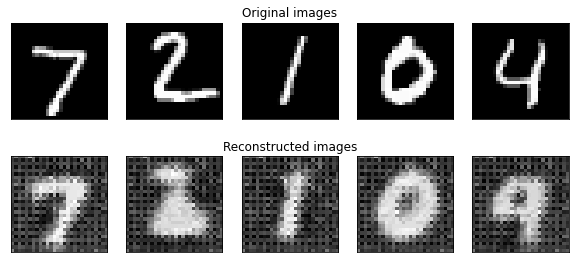

	 partial train loss (single batch): 0.064776
	 partial train loss (single batch): 0.065435
	 partial train loss (single batch): 0.066989
	 partial train loss (single batch): 0.065082
	 partial train loss (single batch): 0.065170
	 partial train loss (single batch): 0.063970
	 partial train loss (single batch): 0.065223
	 partial train loss (single batch): 0.065245
	 partial train loss (single batch): 0.064395
	 partial train loss (single batch): 0.062975
	 partial train loss (single batch): 0.063560
	 partial train loss (single batch): 0.062895
	 partial train loss (single batch): 0.062448
	 partial train loss (single batch): 0.063153
	 partial train loss (single batch): 0.063593
	 partial train loss (single batch): 0.062526
	 partial train loss (single batch): 0.061476
	 partial train loss (single batch): 0.062319
	 partial train loss (single batch): 0.062594
	 partial train loss (single batch): 0.061462
	 partial train loss (single batch): 0.061085
	 partial train loss (single batch

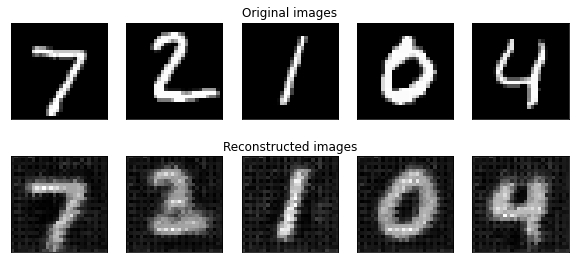

	 partial train loss (single batch): 0.045501
	 partial train loss (single batch): 0.045983
	 partial train loss (single batch): 0.048936
	 partial train loss (single batch): 0.046270
	 partial train loss (single batch): 0.046322
	 partial train loss (single batch): 0.045431
	 partial train loss (single batch): 0.047223
	 partial train loss (single batch): 0.047085
	 partial train loss (single batch): 0.046587
	 partial train loss (single batch): 0.045189
	 partial train loss (single batch): 0.045565
	 partial train loss (single batch): 0.045053
	 partial train loss (single batch): 0.044741
	 partial train loss (single batch): 0.045293
	 partial train loss (single batch): 0.046956
	 partial train loss (single batch): 0.045399
	 partial train loss (single batch): 0.044199
	 partial train loss (single batch): 0.045751
	 partial train loss (single batch): 0.046312
	 partial train loss (single batch): 0.044817
	 partial train loss (single batch): 0.045335
	 partial train loss (single batch

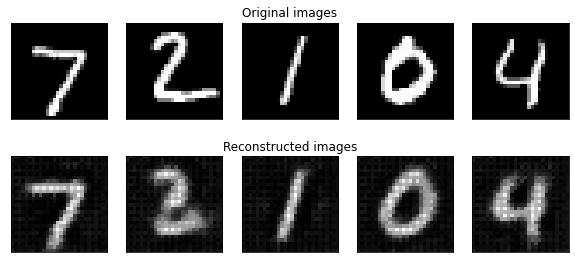

	 partial train loss (single batch): 0.036712
	 partial train loss (single batch): 0.036482
	 partial train loss (single batch): 0.040114
	 partial train loss (single batch): 0.037449
	 partial train loss (single batch): 0.037600
	 partial train loss (single batch): 0.036992
	 partial train loss (single batch): 0.037817
	 partial train loss (single batch): 0.038092
	 partial train loss (single batch): 0.037776
	 partial train loss (single batch): 0.036243
	 partial train loss (single batch): 0.036453
	 partial train loss (single batch): 0.036379
	 partial train loss (single batch): 0.035573
	 partial train loss (single batch): 0.036647
	 partial train loss (single batch): 0.038424
	 partial train loss (single batch): 0.036403
	 partial train loss (single batch): 0.035540
	 partial train loss (single batch): 0.037045
	 partial train loss (single batch): 0.037711
	 partial train loss (single batch): 0.036334
	 partial train loss (single batch): 0.037250
	 partial train loss (single batch

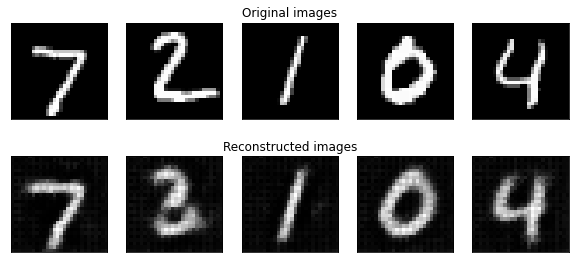

	 partial train loss (single batch): 0.032169
	 partial train loss (single batch): 0.031688
	 partial train loss (single batch): 0.035701
	 partial train loss (single batch): 0.033192
	 partial train loss (single batch): 0.033291
	 partial train loss (single batch): 0.032761
	 partial train loss (single batch): 0.033340
	 partial train loss (single batch): 0.033653
	 partial train loss (single batch): 0.033395
	 partial train loss (single batch): 0.032164
	 partial train loss (single batch): 0.032321
	 partial train loss (single batch): 0.032299
	 partial train loss (single batch): 0.031421
	 partial train loss (single batch): 0.032379
	 partial train loss (single batch): 0.034393
	 partial train loss (single batch): 0.032123
	 partial train loss (single batch): 0.031552
	 partial train loss (single batch): 0.032896
	 partial train loss (single batch): 0.033837
	 partial train loss (single batch): 0.032169
	 partial train loss (single batch): 0.033610
	 partial train loss (single batch

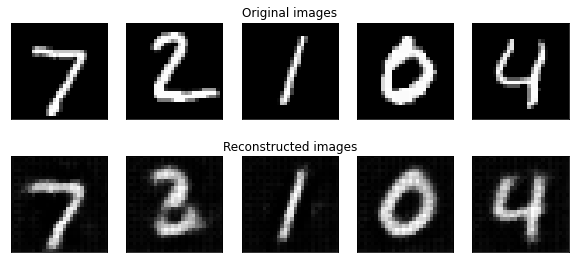

	 partial train loss (single batch): 0.030110
	 partial train loss (single batch): 0.029841
	 partial train loss (single batch): 0.033601
	 partial train loss (single batch): 0.031053
	 partial train loss (single batch): 0.031403
	 partial train loss (single batch): 0.030765
	 partial train loss (single batch): 0.031317
	 partial train loss (single batch): 0.031638
	 partial train loss (single batch): 0.031240
	 partial train loss (single batch): 0.029977
	 partial train loss (single batch): 0.030503
	 partial train loss (single batch): 0.030313
	 partial train loss (single batch): 0.029220
	 partial train loss (single batch): 0.030300
	 partial train loss (single batch): 0.032210
	 partial train loss (single batch): 0.030018
	 partial train loss (single batch): 0.029434
	 partial train loss (single batch): 0.030717
	 partial train loss (single batch): 0.031783
	 partial train loss (single batch): 0.030163
	 partial train loss (single batch): 0.031636
	 partial train loss (single batch

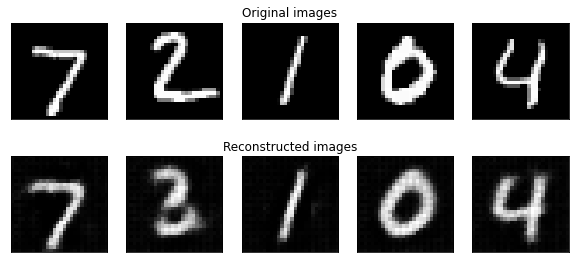

	 partial train loss (single batch): 0.028963
	 partial train loss (single batch): 0.028859
	 partial train loss (single batch): 0.032370
	 partial train loss (single batch): 0.029874
	 partial train loss (single batch): 0.030207
	 partial train loss (single batch): 0.029731
	 partial train loss (single batch): 0.030329
	 partial train loss (single batch): 0.030554
	 partial train loss (single batch): 0.029966
	 partial train loss (single batch): 0.028873
	 partial train loss (single batch): 0.029294
	 partial train loss (single batch): 0.029267
	 partial train loss (single batch): 0.027874
	 partial train loss (single batch): 0.029082
	 partial train loss (single batch): 0.030985
	 partial train loss (single batch): 0.028852
	 partial train loss (single batch): 0.028191
	 partial train loss (single batch): 0.029538
	 partial train loss (single batch): 0.030696
	 partial train loss (single batch): 0.029106
	 partial train loss (single batch): 0.030444
	 partial train loss (single batch

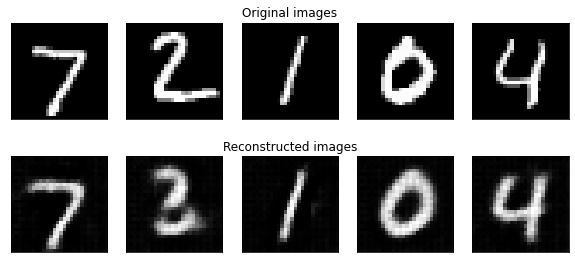

	 partial train loss (single batch): 0.028086
	 partial train loss (single batch): 0.028053
	 partial train loss (single batch): 0.031642
	 partial train loss (single batch): 0.029043
	 partial train loss (single batch): 0.029381
	 partial train loss (single batch): 0.028968
	 partial train loss (single batch): 0.029728
	 partial train loss (single batch): 0.029927
	 partial train loss (single batch): 0.029186
	 partial train loss (single batch): 0.028200
	 partial train loss (single batch): 0.028651
	 partial train loss (single batch): 0.028519
	 partial train loss (single batch): 0.027106
	 partial train loss (single batch): 0.028445
	 partial train loss (single batch): 0.030202
	 partial train loss (single batch): 0.028134
	 partial train loss (single batch): 0.027443
	 partial train loss (single batch): 0.028827
	 partial train loss (single batch): 0.030020
	 partial train loss (single batch): 0.028447
	 partial train loss (single batch): 0.029768
	 partial train loss (single batch

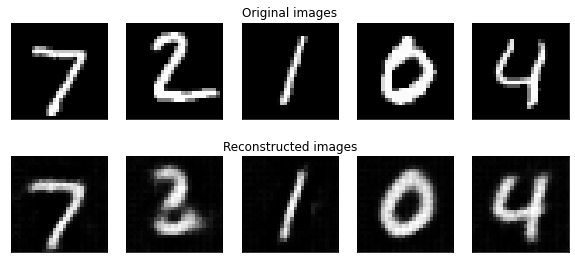

	 partial train loss (single batch): 0.027329
	 partial train loss (single batch): 0.027425
	 partial train loss (single batch): 0.031041
	 partial train loss (single batch): 0.028550
	 partial train loss (single batch): 0.028735
	 partial train loss (single batch): 0.028426
	 partial train loss (single batch): 0.029179
	 partial train loss (single batch): 0.029488
	 partial train loss (single batch): 0.028568
	 partial train loss (single batch): 0.027690
	 partial train loss (single batch): 0.028146
	 partial train loss (single batch): 0.028007
	 partial train loss (single batch): 0.026522
	 partial train loss (single batch): 0.027748
	 partial train loss (single batch): 0.029590
	 partial train loss (single batch): 0.027564
	 partial train loss (single batch): 0.026931
	 partial train loss (single batch): 0.028313
	 partial train loss (single batch): 0.029489
	 partial train loss (single batch): 0.027840
	 partial train loss (single batch): 0.029210
	 partial train loss (single batch

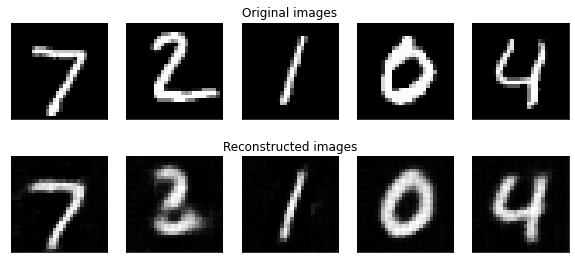

	 partial train loss (single batch): 0.026710
	 partial train loss (single batch): 0.026948
	 partial train loss (single batch): 0.030562
	 partial train loss (single batch): 0.028145
	 partial train loss (single batch): 0.028243
	 partial train loss (single batch): 0.028013
	 partial train loss (single batch): 0.028784
	 partial train loss (single batch): 0.029019
	 partial train loss (single batch): 0.028018
	 partial train loss (single batch): 0.027254
	 partial train loss (single batch): 0.027569
	 partial train loss (single batch): 0.027593
	 partial train loss (single batch): 0.026143
	 partial train loss (single batch): 0.027290
	 partial train loss (single batch): 0.029064
	 partial train loss (single batch): 0.027176
	 partial train loss (single batch): 0.026541
	 partial train loss (single batch): 0.027887
	 partial train loss (single batch): 0.029006
	 partial train loss (single batch): 0.027459
	 partial train loss (single batch): 0.028759
	 partial train loss (single batch

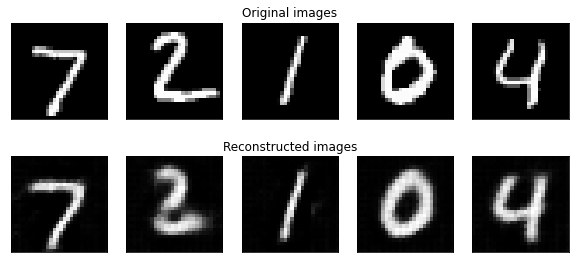

	 partial train loss (single batch): 0.026292
	 partial train loss (single batch): 0.026596
	 partial train loss (single batch): 0.030160
	 partial train loss (single batch): 0.027903
	 partial train loss (single batch): 0.027979
	 partial train loss (single batch): 0.027657
	 partial train loss (single batch): 0.028446
	 partial train loss (single batch): 0.028702
	 partial train loss (single batch): 0.027550
	 partial train loss (single batch): 0.026881
	 partial train loss (single batch): 0.027222
	 partial train loss (single batch): 0.027381
	 partial train loss (single batch): 0.025874
	 partial train loss (single batch): 0.026919
	 partial train loss (single batch): 0.028767
	 partial train loss (single batch): 0.026825
	 partial train loss (single batch): 0.026187
	 partial train loss (single batch): 0.027530
	 partial train loss (single batch): 0.028607
	 partial train loss (single batch): 0.027070
	 partial train loss (single batch): 0.028425
	 partial train loss (single batch

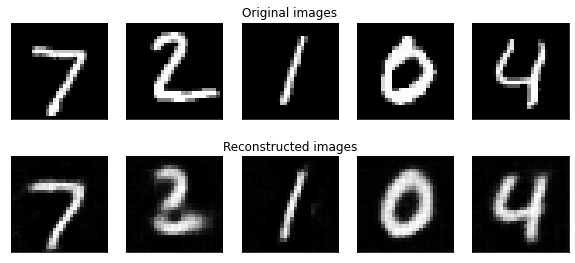

	 partial train loss (single batch): 0.025856
	 partial train loss (single batch): 0.026280
	 partial train loss (single batch): 0.029911
	 partial train loss (single batch): 0.027576
	 partial train loss (single batch): 0.027606
	 partial train loss (single batch): 0.027274
	 partial train loss (single batch): 0.028162
	 partial train loss (single batch): 0.028454
	 partial train loss (single batch): 0.027274
	 partial train loss (single batch): 0.026508
	 partial train loss (single batch): 0.026955
	 partial train loss (single batch): 0.027162
	 partial train loss (single batch): 0.025617
	 partial train loss (single batch): 0.026633
	 partial train loss (single batch): 0.028475
	 partial train loss (single batch): 0.026437
	 partial train loss (single batch): 0.025915
	 partial train loss (single batch): 0.027238
	 partial train loss (single batch): 0.028379
	 partial train loss (single batch): 0.026856
	 partial train loss (single batch): 0.028065
	 partial train loss (single batch

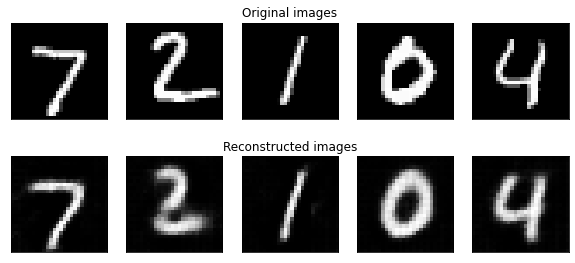

	 partial train loss (single batch): 0.025580
	 partial train loss (single batch): 0.025932
	 partial train loss (single batch): 0.029647
	 partial train loss (single batch): 0.027418
	 partial train loss (single batch): 0.027323
	 partial train loss (single batch): 0.027045
	 partial train loss (single batch): 0.028166
	 partial train loss (single batch): 0.028215
	 partial train loss (single batch): 0.027005
	 partial train loss (single batch): 0.026297
	 partial train loss (single batch): 0.026810
	 partial train loss (single batch): 0.026979
	 partial train loss (single batch): 0.025406
	 partial train loss (single batch): 0.026360
	 partial train loss (single batch): 0.028161
	 partial train loss (single batch): 0.026204
	 partial train loss (single batch): 0.025693
	 partial train loss (single batch): 0.026920
	 partial train loss (single batch): 0.028079
	 partial train loss (single batch): 0.026604
	 partial train loss (single batch): 0.027819
	 partial train loss (single batch

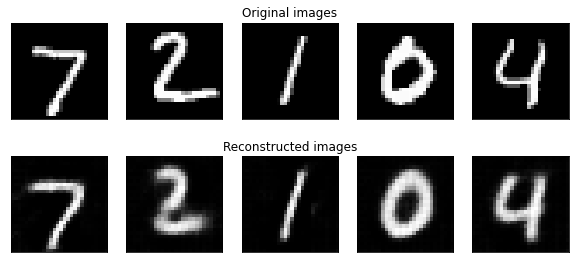

	 partial train loss (single batch): 0.025326
	 partial train loss (single batch): 0.025740
	 partial train loss (single batch): 0.029406
	 partial train loss (single batch): 0.027202
	 partial train loss (single batch): 0.027036
	 partial train loss (single batch): 0.026805
	 partial train loss (single batch): 0.028004
	 partial train loss (single batch): 0.028011
	 partial train loss (single batch): 0.026766
	 partial train loss (single batch): 0.026135
	 partial train loss (single batch): 0.026550
	 partial train loss (single batch): 0.026759
	 partial train loss (single batch): 0.025158
	 partial train loss (single batch): 0.026118
	 partial train loss (single batch): 0.027832
	 partial train loss (single batch): 0.025996
	 partial train loss (single batch): 0.025421
	 partial train loss (single batch): 0.026719
	 partial train loss (single batch): 0.027809
	 partial train loss (single batch): 0.026355
	 partial train loss (single batch): 0.027536
	 partial train loss (single batch

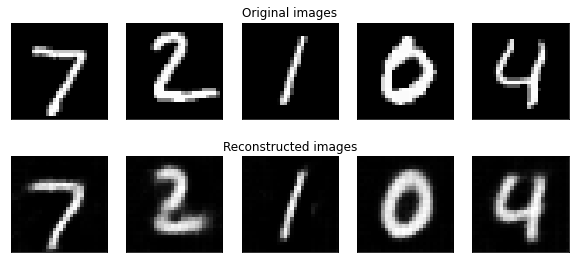

	 partial train loss (single batch): 0.025047
	 partial train loss (single batch): 0.025599
	 partial train loss (single batch): 0.029161
	 partial train loss (single batch): 0.027034
	 partial train loss (single batch): 0.026840
	 partial train loss (single batch): 0.026595
	 partial train loss (single batch): 0.027856
	 partial train loss (single batch): 0.027846
	 partial train loss (single batch): 0.026548
	 partial train loss (single batch): 0.026060
	 partial train loss (single batch): 0.026483
	 partial train loss (single batch): 0.026555
	 partial train loss (single batch): 0.024967
	 partial train loss (single batch): 0.025985
	 partial train loss (single batch): 0.027646
	 partial train loss (single batch): 0.025815
	 partial train loss (single batch): 0.025313
	 partial train loss (single batch): 0.026530
	 partial train loss (single batch): 0.027594
	 partial train loss (single batch): 0.026141
	 partial train loss (single batch): 0.027272
	 partial train loss (single batch

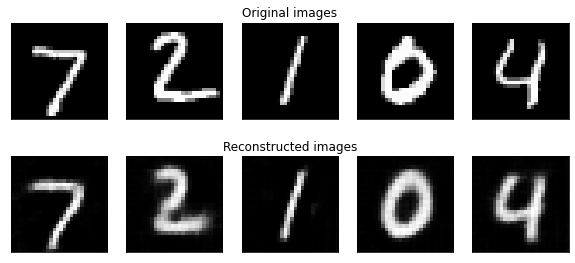

	 partial train loss (single batch): 0.024866
	 partial train loss (single batch): 0.025461
	 partial train loss (single batch): 0.028964
	 partial train loss (single batch): 0.026804
	 partial train loss (single batch): 0.026597
	 partial train loss (single batch): 0.026424
	 partial train loss (single batch): 0.027777
	 partial train loss (single batch): 0.027709
	 partial train loss (single batch): 0.026379
	 partial train loss (single batch): 0.025842
	 partial train loss (single batch): 0.026298
	 partial train loss (single batch): 0.026361
	 partial train loss (single batch): 0.024819
	 partial train loss (single batch): 0.025806
	 partial train loss (single batch): 0.027480
	 partial train loss (single batch): 0.025602
	 partial train loss (single batch): 0.025222
	 partial train loss (single batch): 0.026329
	 partial train loss (single batch): 0.027443
	 partial train loss (single batch): 0.026039
	 partial train loss (single batch): 0.027075
	 partial train loss (single batch

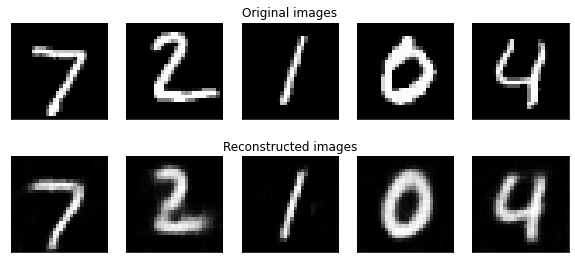

	 partial train loss (single batch): 0.024726
	 partial train loss (single batch): 0.025306
	 partial train loss (single batch): 0.028794
	 partial train loss (single batch): 0.026624
	 partial train loss (single batch): 0.026440
	 partial train loss (single batch): 0.026276
	 partial train loss (single batch): 0.027611
	 partial train loss (single batch): 0.027642
	 partial train loss (single batch): 0.026210
	 partial train loss (single batch): 0.025710
	 partial train loss (single batch): 0.026073
	 partial train loss (single batch): 0.026211
	 partial train loss (single batch): 0.024659
	 partial train loss (single batch): 0.025635
	 partial train loss (single batch): 0.027284
	 partial train loss (single batch): 0.025399
	 partial train loss (single batch): 0.025086
	 partial train loss (single batch): 0.026142
	 partial train loss (single batch): 0.027233
	 partial train loss (single batch): 0.025906
	 partial train loss (single batch): 0.026904
	 partial train loss (single batch

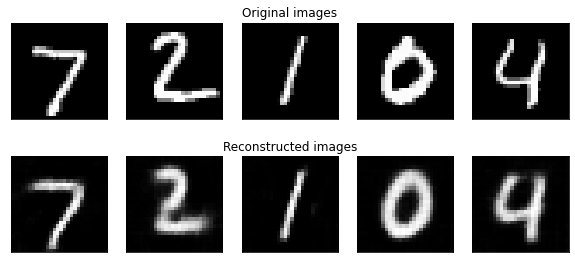

	 partial train loss (single batch): 0.024557
	 partial train loss (single batch): 0.025221
	 partial train loss (single batch): 0.028660
	 partial train loss (single batch): 0.026482
	 partial train loss (single batch): 0.026408
	 partial train loss (single batch): 0.026105
	 partial train loss (single batch): 0.027515
	 partial train loss (single batch): 0.027565
	 partial train loss (single batch): 0.026094
	 partial train loss (single batch): 0.025627
	 partial train loss (single batch): 0.026032
	 partial train loss (single batch): 0.026102
	 partial train loss (single batch): 0.024500
	 partial train loss (single batch): 0.025564
	 partial train loss (single batch): 0.027151
	 partial train loss (single batch): 0.025191
	 partial train loss (single batch): 0.025042
	 partial train loss (single batch): 0.026107
	 partial train loss (single batch): 0.027124
	 partial train loss (single batch): 0.025845
	 partial train loss (single batch): 0.026815
	 partial train loss (single batch

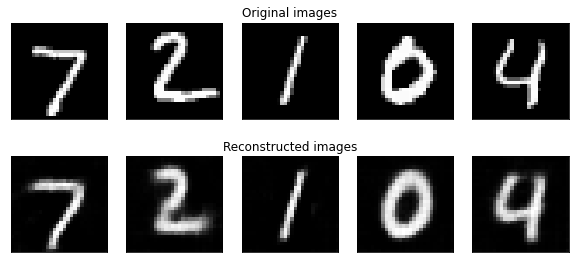

	 partial train loss (single batch): 0.024415
	 partial train loss (single batch): 0.025156
	 partial train loss (single batch): 0.028556
	 partial train loss (single batch): 0.026354
	 partial train loss (single batch): 0.026222
	 partial train loss (single batch): 0.025987
	 partial train loss (single batch): 0.027408
	 partial train loss (single batch): 0.027458
	 partial train loss (single batch): 0.026051
	 partial train loss (single batch): 0.025501
	 partial train loss (single batch): 0.025892
	 partial train loss (single batch): 0.025955
	 partial train loss (single batch): 0.024405
	 partial train loss (single batch): 0.025441
	 partial train loss (single batch): 0.027084
	 partial train loss (single batch): 0.025031
	 partial train loss (single batch): 0.024946
	 partial train loss (single batch): 0.026054
	 partial train loss (single batch): 0.026977
	 partial train loss (single batch): 0.025701
	 partial train loss (single batch): 0.026730
	 partial train loss (single batch

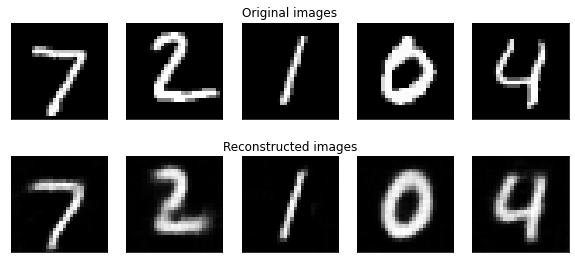

	 partial train loss (single batch): 0.024312
	 partial train loss (single batch): 0.025034
	 partial train loss (single batch): 0.028459
	 partial train loss (single batch): 0.026236
	 partial train loss (single batch): 0.026168
	 partial train loss (single batch): 0.025912
	 partial train loss (single batch): 0.027256
	 partial train loss (single batch): 0.027344
	 partial train loss (single batch): 0.026014
	 partial train loss (single batch): 0.025305
	 partial train loss (single batch): 0.025764
	 partial train loss (single batch): 0.025861
	 partial train loss (single batch): 0.024265
	 partial train loss (single batch): 0.025360
	 partial train loss (single batch): 0.026994
	 partial train loss (single batch): 0.024969
	 partial train loss (single batch): 0.024799
	 partial train loss (single batch): 0.026014
	 partial train loss (single batch): 0.026919
	 partial train loss (single batch): 0.025542
	 partial train loss (single batch): 0.026567
	 partial train loss (single batch

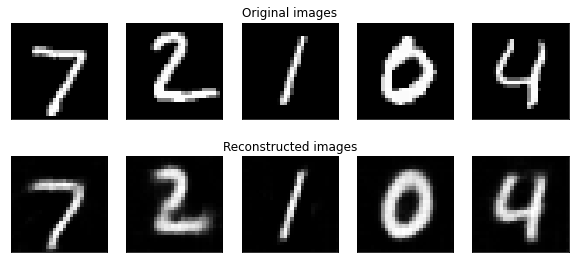

	 partial train loss (single batch): 0.024143
	 partial train loss (single batch): 0.024954
	 partial train loss (single batch): 0.028432
	 partial train loss (single batch): 0.026157
	 partial train loss (single batch): 0.025998
	 partial train loss (single batch): 0.025824
	 partial train loss (single batch): 0.027152
	 partial train loss (single batch): 0.027241
	 partial train loss (single batch): 0.026007
	 partial train loss (single batch): 0.025249
	 partial train loss (single batch): 0.025614
	 partial train loss (single batch): 0.025735
	 partial train loss (single batch): 0.024168
	 partial train loss (single batch): 0.025247
	 partial train loss (single batch): 0.026847
	 partial train loss (single batch): 0.024861
	 partial train loss (single batch): 0.024678
	 partial train loss (single batch): 0.025881
	 partial train loss (single batch): 0.026825
	 partial train loss (single batch): 0.025415
	 partial train loss (single batch): 0.026413
	 partial train loss (single batch

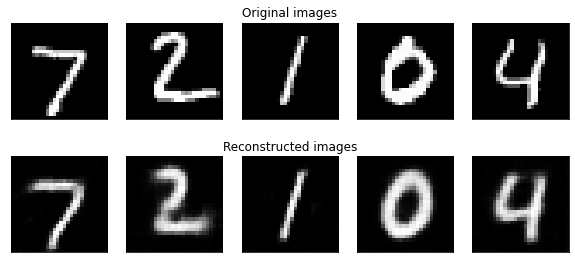

	 partial train loss (single batch): 0.024004
	 partial train loss (single batch): 0.024822
	 partial train loss (single batch): 0.028246
	 partial train loss (single batch): 0.026003
	 partial train loss (single batch): 0.025903
	 partial train loss (single batch): 0.025728
	 partial train loss (single batch): 0.027035
	 partial train loss (single batch): 0.027116
	 partial train loss (single batch): 0.025851
	 partial train loss (single batch): 0.025141
	 partial train loss (single batch): 0.025476
	 partial train loss (single batch): 0.025646
	 partial train loss (single batch): 0.024014
	 partial train loss (single batch): 0.025125
	 partial train loss (single batch): 0.026715
	 partial train loss (single batch): 0.024725
	 partial train loss (single batch): 0.024512
	 partial train loss (single batch): 0.025758
	 partial train loss (single batch): 0.026769
	 partial train loss (single batch): 0.025353
	 partial train loss (single batch): 0.026301
	 partial train loss (single batch

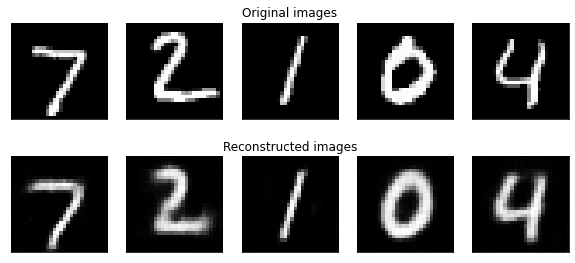

	 partial train loss (single batch): 0.023897
	 partial train loss (single batch): 0.024773
	 partial train loss (single batch): 0.028094
	 partial train loss (single batch): 0.025914
	 partial train loss (single batch): 0.025760
	 partial train loss (single batch): 0.025551
	 partial train loss (single batch): 0.027048
	 partial train loss (single batch): 0.026990
	 partial train loss (single batch): 0.025760
	 partial train loss (single batch): 0.025040
	 partial train loss (single batch): 0.025441
	 partial train loss (single batch): 0.025537
	 partial train loss (single batch): 0.023969
	 partial train loss (single batch): 0.025035
	 partial train loss (single batch): 0.026585
	 partial train loss (single batch): 0.024669
	 partial train loss (single batch): 0.024428
	 partial train loss (single batch): 0.025726
	 partial train loss (single batch): 0.026622
	 partial train loss (single batch): 0.025209
	 partial train loss (single batch): 0.026180
	 partial train loss (single batch

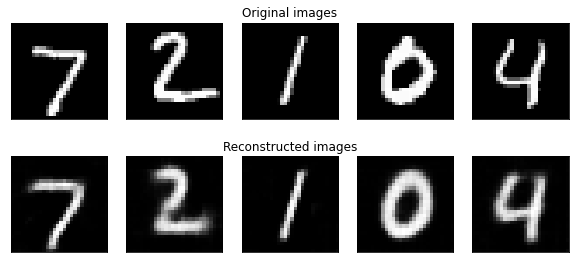

	 partial train loss (single batch): 0.023819
	 partial train loss (single batch): 0.024692
	 partial train loss (single batch): 0.028064
	 partial train loss (single batch): 0.025768
	 partial train loss (single batch): 0.025607
	 partial train loss (single batch): 0.025518
	 partial train loss (single batch): 0.026935
	 partial train loss (single batch): 0.026872
	 partial train loss (single batch): 0.025700
	 partial train loss (single batch): 0.024979
	 partial train loss (single batch): 0.025378
	 partial train loss (single batch): 0.025408
	 partial train loss (single batch): 0.023842
	 partial train loss (single batch): 0.024939
	 partial train loss (single batch): 0.026546
	 partial train loss (single batch): 0.024572
	 partial train loss (single batch): 0.024337
	 partial train loss (single batch): 0.025660
	 partial train loss (single batch): 0.026590
	 partial train loss (single batch): 0.025170
	 partial train loss (single batch): 0.026101
	 partial train loss (single batch

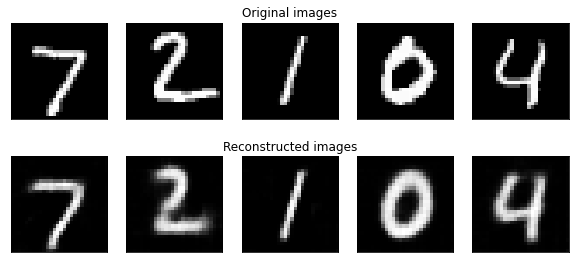

	 partial train loss (single batch): 0.023729
	 partial train loss (single batch): 0.024570
	 partial train loss (single batch): 0.027890
	 partial train loss (single batch): 0.025670
	 partial train loss (single batch): 0.025459
	 partial train loss (single batch): 0.025416
	 partial train loss (single batch): 0.026876
	 partial train loss (single batch): 0.026738
	 partial train loss (single batch): 0.025651
	 partial train loss (single batch): 0.024898
	 partial train loss (single batch): 0.025313
	 partial train loss (single batch): 0.025309
	 partial train loss (single batch): 0.023746
	 partial train loss (single batch): 0.024880
	 partial train loss (single batch): 0.026380
	 partial train loss (single batch): 0.024515
	 partial train loss (single batch): 0.024252
	 partial train loss (single batch): 0.025528
	 partial train loss (single batch): 0.026471
	 partial train loss (single batch): 0.025106
	 partial train loss (single batch): 0.025979
	 partial train loss (single batch

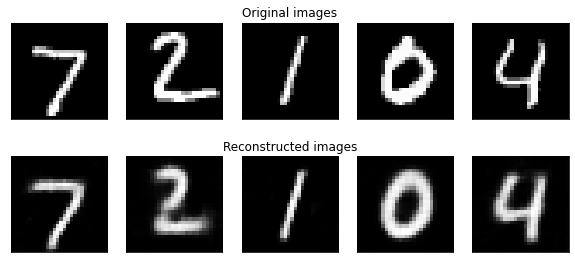

	 partial train loss (single batch): 0.023564
	 partial train loss (single batch): 0.024492
	 partial train loss (single batch): 0.027832
	 partial train loss (single batch): 0.025666
	 partial train loss (single batch): 0.025440
	 partial train loss (single batch): 0.025340
	 partial train loss (single batch): 0.026855
	 partial train loss (single batch): 0.026727
	 partial train loss (single batch): 0.025606
	 partial train loss (single batch): 0.024859
	 partial train loss (single batch): 0.025299
	 partial train loss (single batch): 0.025236
	 partial train loss (single batch): 0.023737
	 partial train loss (single batch): 0.024856
	 partial train loss (single batch): 0.026293
	 partial train loss (single batch): 0.024481
	 partial train loss (single batch): 0.024202
	 partial train loss (single batch): 0.025473
	 partial train loss (single batch): 0.026462
	 partial train loss (single batch): 0.025042
	 partial train loss (single batch): 0.025906
	 partial train loss (single batch

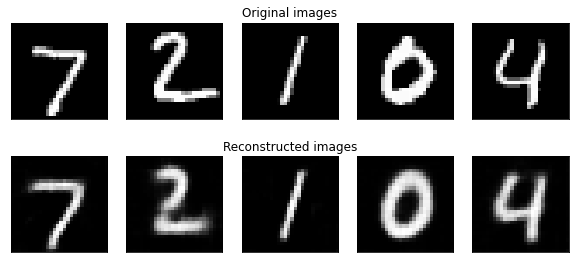

	 partial train loss (single batch): 0.023463
	 partial train loss (single batch): 0.024401
	 partial train loss (single batch): 0.027779
	 partial train loss (single batch): 0.025543
	 partial train loss (single batch): 0.025359
	 partial train loss (single batch): 0.025236
	 partial train loss (single batch): 0.026763
	 partial train loss (single batch): 0.026601
	 partial train loss (single batch): 0.025569
	 partial train loss (single batch): 0.024827
	 partial train loss (single batch): 0.025243
	 partial train loss (single batch): 0.025164
	 partial train loss (single batch): 0.023657
	 partial train loss (single batch): 0.024843
	 partial train loss (single batch): 0.026261
	 partial train loss (single batch): 0.024422
	 partial train loss (single batch): 0.024129
	 partial train loss (single batch): 0.025369
	 partial train loss (single batch): 0.026384
	 partial train loss (single batch): 0.025050
	 partial train loss (single batch): 0.025892
	 partial train loss (single batch

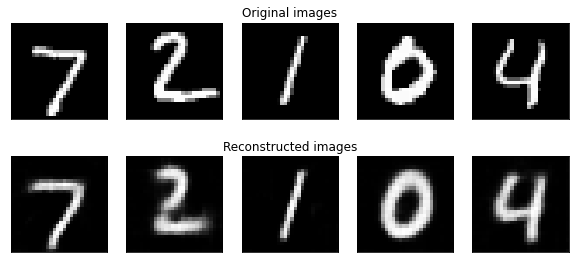

	 partial train loss (single batch): 0.023429
	 partial train loss (single batch): 0.024394
	 partial train loss (single batch): 0.027726
	 partial train loss (single batch): 0.025522
	 partial train loss (single batch): 0.025309
	 partial train loss (single batch): 0.025198
	 partial train loss (single batch): 0.026721
	 partial train loss (single batch): 0.026573
	 partial train loss (single batch): 0.025507
	 partial train loss (single batch): 0.024744
	 partial train loss (single batch): 0.025222
	 partial train loss (single batch): 0.025075
	 partial train loss (single batch): 0.023637
	 partial train loss (single batch): 0.024732
	 partial train loss (single batch): 0.026193
	 partial train loss (single batch): 0.024350
	 partial train loss (single batch): 0.024083
	 partial train loss (single batch): 0.025294
	 partial train loss (single batch): 0.026265
	 partial train loss (single batch): 0.024890
	 partial train loss (single batch): 0.025811
	 partial train loss (single batch

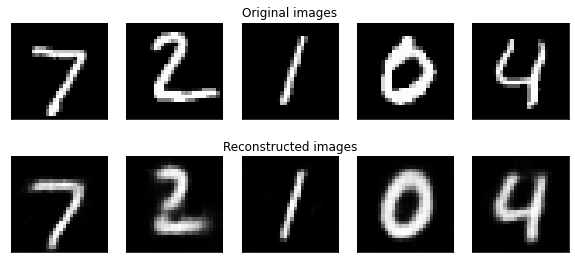

	 partial train loss (single batch): 0.023317
	 partial train loss (single batch): 0.024308
	 partial train loss (single batch): 0.027664
	 partial train loss (single batch): 0.025421
	 partial train loss (single batch): 0.025253
	 partial train loss (single batch): 0.025142
	 partial train loss (single batch): 0.026616
	 partial train loss (single batch): 0.026469
	 partial train loss (single batch): 0.025508
	 partial train loss (single batch): 0.024693
	 partial train loss (single batch): 0.025155
	 partial train loss (single batch): 0.025039
	 partial train loss (single batch): 0.023626
	 partial train loss (single batch): 0.024699
	 partial train loss (single batch): 0.026060
	 partial train loss (single batch): 0.024345
	 partial train loss (single batch): 0.024037
	 partial train loss (single batch): 0.025227
	 partial train loss (single batch): 0.026179
	 partial train loss (single batch): 0.024919
	 partial train loss (single batch): 0.025803
	 partial train loss (single batch

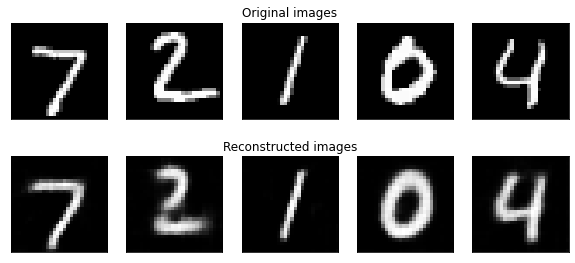

	 partial train loss (single batch): 0.023373
	 partial train loss (single batch): 0.024333
	 partial train loss (single batch): 0.027581
	 partial train loss (single batch): 0.025348
	 partial train loss (single batch): 0.025137
	 partial train loss (single batch): 0.025102
	 partial train loss (single batch): 0.026550
	 partial train loss (single batch): 0.026419
	 partial train loss (single batch): 0.025439
	 partial train loss (single batch): 0.024628
	 partial train loss (single batch): 0.025055
	 partial train loss (single batch): 0.024980
	 partial train loss (single batch): 0.023474
	 partial train loss (single batch): 0.024592
	 partial train loss (single batch): 0.026008
	 partial train loss (single batch): 0.024228
	 partial train loss (single batch): 0.023989
	 partial train loss (single batch): 0.025101
	 partial train loss (single batch): 0.026145
	 partial train loss (single batch): 0.024860
	 partial train loss (single batch): 0.025794
	 partial train loss (single batch

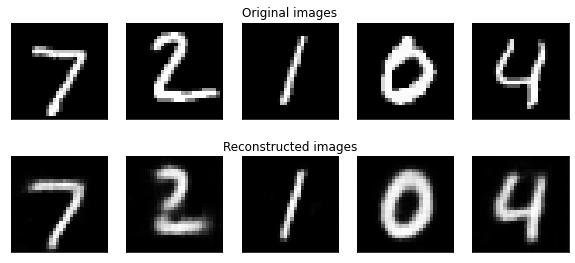

In [26]:
num_epochs = 30
history={'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):

   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   history['train_loss'].append(train_loss)
   history['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=5)

In [27]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.02610103413462639

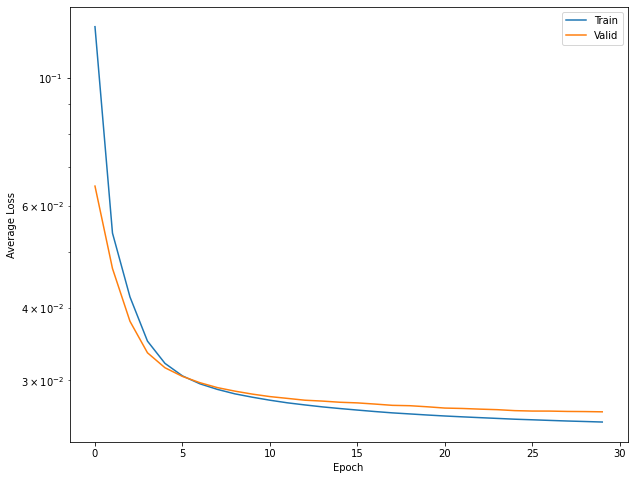

In [28]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

#5. Generate new samples from the latent code

In [29]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

In [30]:
plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))

RuntimeError: ignored

<Figure size 1440x612 with 0 Axes>

In [31]:
encoded_samples = []
for sample in tqdm(test_data):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:11<00:00, 906.77it/s]


In [32]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-2.626966,1.044024,0.960520,-0.206882,7
1,0.256435,0.450385,1.012742,0.475864,2
2,-0.744534,1.241034,0.208029,1.477965,1
3,0.342910,-0.733879,-0.151406,-0.406071,0
4,-0.369034,0.361648,-1.050146,-0.393722,4
...,...,...,...,...,...
9995,-0.552799,0.289438,1.522729,0.434994,2
9996,0.439427,0.258350,0.758388,-0.016893,3
9997,-0.984246,0.413224,-1.006878,0.506120,4
9998,-0.220701,-0.515103,0.001303,0.468574,5


In [33]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

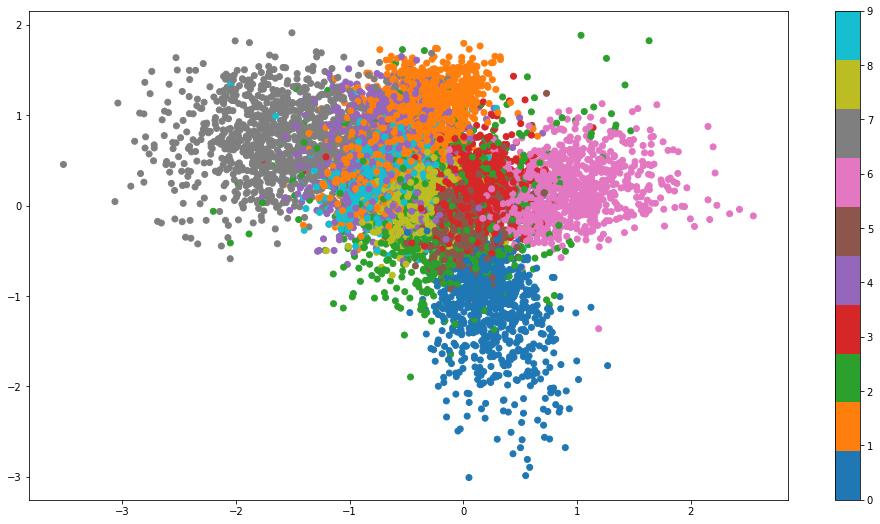

In [34]:
plt.figure(figsize=(17, 9))
plt.scatter(encoded_samples['Enc. Variable 0'], encoded_samples['Enc. Variable 1'], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()

In [35]:
pca = PCA(n_components=2)
components = pca.fit_transform(encoded_samples.drop(['label'],axis=1))
total_var = pca.explained_variance_ratio_.sum() * 100
print(total_var)

71.01958990097046


In [36]:
fig = px.scatter(components, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'PC 1', '1': 'PC 2'})
fig.show()

In [37]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [38]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()